<a href="https://colab.research.google.com/github/NitinShindeJ/TensorFlow2.0/blob/master/My_learn_TF2.0/TF2_0_DeepLearning_TransferLearning_WithDataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0-rc3


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [0]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image

In [0]:
#Transfer Learning Imports
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from glob import glob

In [0]:
#Data set fo Binary classification
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
#!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!wget -nc https://github.com/NitinShindeJ/TensorFlow2.0.git//Data/Food_Data.zip

In [0]:
!unzip -qq -o Food-5K.zip

In [8]:
!ls 

Data  Food_Data.zip  sample_data


In [0]:
#Files in training 
!ls Food-5K/training

In [0]:
!mv Food-5K/* 

In [0]:
# look at an image for fun
plt.imshow(image.load_img('training/0_410.jpg'))
plt.show()

In [0]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [0]:
#Making folder Data
!mkdir data

In [0]:
# Make directories to store the data Keras-style
#making folders 
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
!unzip -qq -o Food_Data.zip

In [0]:
train_path = 'Data/train'
valid_path = 'Data/test'

In [0]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [12]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['Data/train/food', 'Data/train/nonfood']

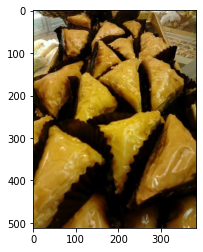

In [15]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [16]:
#VGG Model
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3], #Image size for inpput shape & [3] for color standard
    weights='imagenet',
    include_top=False) #layer upto final conv layer

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# freeze pretrained model weights
ptm.trainable = False

In [0]:
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [0]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [20]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [22]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [24]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
24/24 [==============================] - 1559s 65s/step - loss: 2.2492 - accuracy: 0.9053 - val_loss: 0.4687 - val_accuracy: 0.9790
Epoch 2/10
24/24 [==============================] - 1565s 65s/step - loss: 0.5146 - accuracy: 0.9783 - val_loss: 0.4157 - val_accuracy: 0.9830
Epoch 3/10
24/24 [==============================] - 1561s 65s/step - loss: 0.4015 - accuracy: 0.9810 - val_loss: 0.4833 - val_accuracy: 0.9800
Epoch 4/10
24/24 [==============================] - 1571s 65s/step - loss: 0.2260 - accuracy: 0.9887 - val_loss: 0.6071 - val_accuracy: 0.9680
Epoch 5/10
24/24 [==============================] - 1556s 65s/step - loss: 0.2020 - accuracy: 0.9873 - val_loss: 0.4171 - val_accuracy: 0.9810
Epoch 6/10
24/24 [==============================] - 1561s 65s/step - loss: 0.2237 - accuracy: 0.9847 - val_loss: 0.8547 - val_accuracy: 0.9710
Epoch 7/10
24/24 [==============================] - 1575s 66s/step

In [3]:
# create a 2nd train generator which does not use data augmentation
# to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

NameError: ignored

In [1]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

NameError: ignored

In [0]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()